# Regularization of linear regression model

Neste caderno, veremos as limitações dos modelos de regressão linear e
a vantagem de usar modelos regularizados.

Além disso, também apresentaremos o pré-processamento necessário ao lidar com
com modelos regularizados, além disso quando o parâmetro de regularização
precisa ser ajustado.

Começaremos destacando o problema de ajuste excessivo que pode surgir com
um modelo de regressão linear simples.

## Efeito da regularização

Carregaremos primeiro o conjunto de dados de habitação da Califórnia.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last"> Se você quiser uma visão geral mais detalhada sobre este conjunto de dados, pode consultar o
Apêndice - seção de descrição dos conjuntos de dados no final deste MOOC. </p>
</div>

In [36]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
target *= 100  # rescale the target in k$
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Em um dos notebooks anteriores, mostramos que modelos lineares podem ser usados
mesmo em configurações onde `data` e` target` não estão linearmente vinculados.

Mostramos que é possível usar o transformador `PolynomialFeatures` para criar
recursos adicionais que codificam interações não lineares entre recursos.

Aqui, usaremos este transformador para aumentar o espaço de recursos.
Posteriormente, treinaremos um modelo de regressão linear. Nós vamos usar o
conjunto de teste fora da amostra para avaliar as capacidades de generalização de nosso
modelo.

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(PolynomialFeatures(degree=2),
                                  LinearRegression())
cv_results = cross_validate(linear_regression, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

Podemos comparar o erro quadrático médio no conjunto de treinamento e teste com
avaliar o desempenho de generalização do nosso modelo.

In [3]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regresion model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regresion model on the train set:
4190.212 +/- 151.123


In [4]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regresion model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regresion model on the test set:
13334.943 +/- 20292.678


A pontuação no conjunto de treinamento é muito melhor. Este desempenho estatístico
lacuna entre a pontuação de treinamento e teste é uma indicação de que nosso modelo
sobrecarregou nosso conjunto de treinamento.

Na verdade, este é um dos perigos ao aumentar o número de recursos
com um transformador `PolynomialFeatures`. Nosso modelo se concentrará em alguns
características específicas. Podemos verificar os pesos do modelo para ter um
confirmação. Vamos criar um dataframe: as colunas irão conter o nome
do recurso, enquanto a linha os valores dos coeficientes armazenados por cada modelo
durante a validação cruzada.

Como usamos `PolynomialFeatures` para aumentar os dados, vamos criar
nomes de recursos representativos da combinação de recursos. Scikit-learn
fornece um método `get_feature_names` para este propósito. Primeiro, vamos pegar
o primeiro modelo ajustado da validação cruzada.

In [5]:
model_first_fold = cv_results["estimator"][0]

Agora, podemos acessar os `PolynomialFeatures` ajustados para gerar o recurso
nomes

In [6]:
feature_names = model_first_fold[0].get_feature_names(
    input_features=data.columns)
feature_names

['1',
 'MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'MedInc^2',
 'MedInc HouseAge',
 'MedInc AveRooms',
 'MedInc AveBedrms',
 'MedInc Population',
 'MedInc AveOccup',
 'MedInc Latitude',
 'MedInc Longitude',
 'HouseAge^2',
 'HouseAge AveRooms',
 'HouseAge AveBedrms',
 'HouseAge Population',
 'HouseAge AveOccup',
 'HouseAge Latitude',
 'HouseAge Longitude',
 'AveRooms^2',
 'AveRooms AveBedrms',
 'AveRooms Population',
 'AveRooms AveOccup',
 'AveRooms Latitude',
 'AveRooms Longitude',
 'AveBedrms^2',
 'AveBedrms Population',
 'AveBedrms AveOccup',
 'AveBedrms Latitude',
 'AveBedrms Longitude',
 'Population^2',
 'Population AveOccup',
 'Population Latitude',
 'Population Longitude',
 'AveOccup^2',
 'AveOccup Latitude',
 'AveOccup Longitude',
 'Latitude^2',
 'Latitude Longitude',
 'Longitude^2']

Finalmente, podemos criar o dataframe contendo todas as informações.

In [7]:
import pandas as pd

coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_linear_regression = pd.DataFrame(coefs, columns=feature_names)

Agora, vamos usar um gráfico de caixa para ver as variações dos coeficientes.

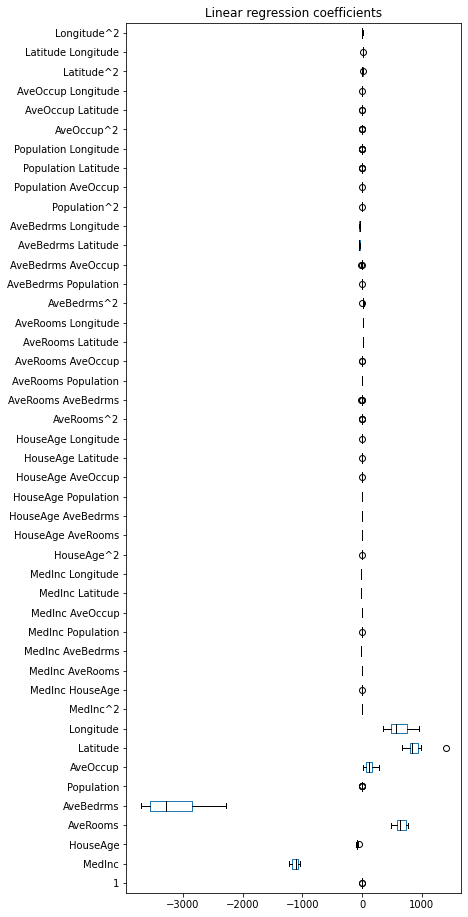

In [8]:
import matplotlib.pyplot as plt

color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_linear_regression.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Linear regression coefficients")

Podemos forçar o modelo de regressão linear a considerar todos os recursos em mais
forma homogênea. Na verdade, poderíamos forçar um grande peso positivo ou negativo
encolher até zero. Isso é conhecido como regularização. Vamos usar um cume
modelo que impõe tal comportamento.

In [9]:
from sklearn.linear_model import Ridge

ridge = make_pipeline(PolynomialFeatures(degree=2),
                      Ridge(alpha=100))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

C:\Users\Rogerio Lopes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.672e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Rogerio Lopes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.67257e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Rogerio Lopes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.75536e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Rogerio Lopes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.67367e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Rogerio Lopes\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.

In [10]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regresion model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regresion model on the train set:
4373.180 +/- 153.942


In [11]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regresion model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regresion model on the test set:
7303.589 +/- 4950.732


Vemos que as pontuações de treinamento e teste estão muito mais próximas, indicando que
nosso modelo é menos overfitting. Podemos comparar os valores dos pesos de
cume com a regressão linear não regularizada.

In [12]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

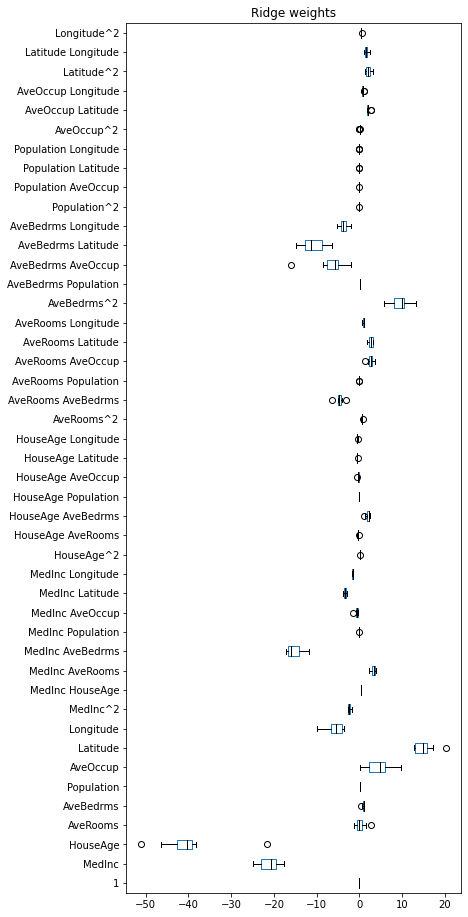

In [13]:
weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights")

Ao comparar a magnitude dos pesos neste gráfico em comparação com o
gráfico anterior, vemos que a magnitude dos pesos é reduzida para
zero em comparação com o modelo de regressão linear.

No entanto, neste exemplo, omitimos dois aspectos importantes: (i) a necessidade de
dimensionar os dados e (ii) a necessidade de buscar a melhor regularização
parâmetro.

## Dimensione seus dados!

A regularização adicionará restrições aos pesos do modelo. Nós vimos no
exemplo anterior de que um modelo de crista fará com que todos os pesos tenham um
magnitude semelhante. Na verdade, quanto maior o alfa, maior é a aplicação
vai ser.

Este procedimento deve nos fazer pensar sobre o reescalonamento de recursos. Vamos considerar
o caso em que os recursos têm uma dispersão de dados idêntica: se dois recursos
são considerados igualmente importantes pelo modelo, eles serão afetados de forma semelhante por
força de regularização.

Agora, vamos considerar o cenário em que os recursos têm diferentes
dispersão de dados (por exemplo, idade em anos e receita anual em dólares).
Se dois recursos forem tão importantes, nosso modelo aumentará os pesos de
recursos com pequena dispersão e reduzem os pesos dos recursos com
alta dispersão.

Lembramos que a regularização força a aproximação dos pesos. Portanto, nós temos
uma intuição de que se quisermos usar regularização, lidar com reescalonamento
dados tornariam mais fácil encontrar um parâmetro de regularização ideal e
portanto, um modelo adequado.

Como uma observação lateral, alguns solucionadores com base na computação de gradiente estão esperando tal
dados redimensionados. Dados não escalonados serão prejudiciais ao calcular o ótimo
pesos. Portanto, ao trabalhar com um modelo linear e dados numéricos,
geralmente é uma boa prática dimensionar os dados.

Assim, adicionaremos um `StandardScaler` no pipeline de aprendizado de máquina. Esse
scaler será colocado antes do regressor.

In [14]:
from sklearn.preprocessing import StandardScaler

ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      Ridge(alpha=0.5))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

In [15]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regresion model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regresion model on the train set:
4347.036 +/- 156.666


In [16]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regresion model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regresion model on the test set:
5508.472 +/- 1816.642


Observamos que os dados de escala têm um impacto positivo na pontuação do teste e que
a pontuação do teste está mais próxima da pontuação do trem. Isso significa que nosso modelo é menos
overfitted e que estamos nos aproximando da melhor generalização doce
ver.

Vamos dar uma olhada adicional nos diferentes pesos.

In [17]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

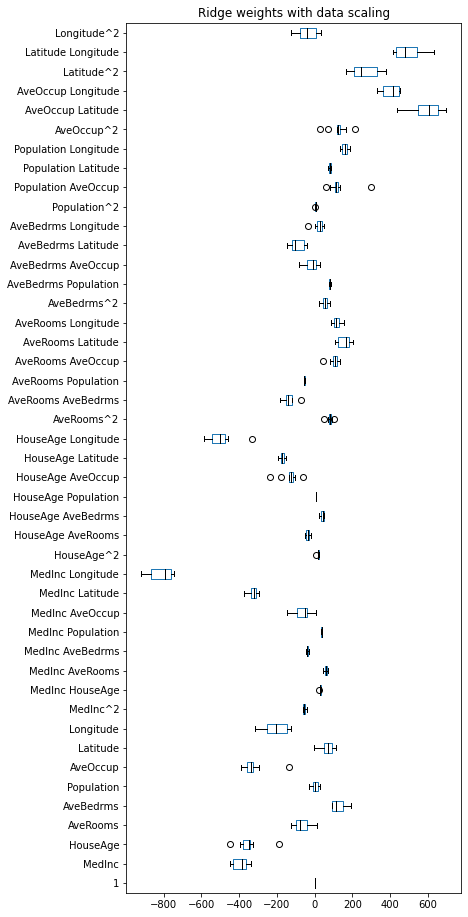

In [18]:
weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights with data scaling")

Compare com os gráficos anteriores, vemos que agora todas as manitudes de peso são
mais perto e que todos os pesos estão contribuindo mais igualmente.

Na análise anterior, não estudamos se o parâmetro `alpha` terá
um efeito no desempenho. Escolhemos o parâmetro de antemão e o corrigimos
para a análise.

Na próxima seção, verificaremos o impacto desse hiperparâmetro e como
deve ser ajustado.

## Ajustando o parâmetro de regularização

Conforme mencionado, o parâmetro de regularização precisa ser ajustado em cada conjunto de dados.
O parâmetro padrão não levará ao modelo ideal. Portanto, precisamos
para ajustar o parâmetro `alpha`.

O ajuste do hiperparâmetro do modelo deve ser feito com cuidado. Na verdade, nós queremos
encontre um parâmetro ideal que maximize algumas métricas. Assim, requer ambos
um conjunto de treinamento e um conjunto de teste.

No entanto, este conjunto de teste deve ser diferente do teste fora da amostra
conjunto que usamos para avaliar nosso modelo: se usarmos o mesmo, estamos usando
um `alpha` que foi otimizado para este conjunto de teste e quebra o
regra fora da amostra.

Portanto, devemos incluir a pesquisa do hiperparâmetro `alfa` dentro do
validação cruzada. Como vimos em notebooks anteriores, poderíamos usar um
grid-search. No entanto, alguns preditores no scikit-learn estão disponíveis com
uma pesquisa de hiperparâmetros integrada, mais eficiente do que usar uma pesquisa em grade.
O nome desses preditores termina com `CV`. No caso de `Ridge`,
O scikit-learn fornece um regressor `RidgeCV`.

Portanto, podemos usar esse preditor como a última etapa do pipeline.
Incluindo o pipeline, uma validação cruzada permite fazer um aninhado
validação cruzada: a validação cruzada interna irá procurar o melhor
alfa, enquanto a validação cruzada externa dará uma estimativa do
pontuação de teste.

In [19]:
import numpy as np
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-2, 0, num=20)
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      RidgeCV(alphas=alphas, store_cv_values=True))

In [20]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results = cross_validate(ridge, data, target,
                            cv=cv, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=-1)

In [21]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regresion model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regresion model on the train set:
4306.562 +/- 25.918


In [22]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regresion model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regresion model on the test set:
4348.657 +/- 252.921


Ao otimizar `alpha`, vemos que as pontuações de treinamento e teste são fechadas.
Isso indica que nosso modelo não é overfitting.

Ao ajustar o regressor de crista, também solicitamos armazenar o erro encontrado
durante a validação cruzada (definindo o parâmetro `store_cv_values = True`).
Vamos representar graficamente o erro quadrático médio para as diferentes regularizações de `alfas`
força que tentamos.

In [23]:
mse_alphas = [est[-1].cv_values_.mean(axis=0)
              for est in cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas

,0.010000,0.012743,0.016238,0.020691,0.026367,0.033598,0.042813,0.054556,0.069519,0.088587,0.112884,0.143845,0.183298,0.233572,0.297635,0.379269,0.483293,0.615848,0.784760,1.000000
0,7587.897141,7059.531216,6579.796667,6161.839629,5813.048345,5535.350138,5326.646369,5182.950517,5100.749049,5079.212663,5122.029454,5238.704149,5445.118890,5763.012259,6217.925433,6835.274126,7634.692137,8623.620241,9791.918443,11109.476019
1,7079.341771,6696.622046,6329.022308,5987.727181,5681.306000,5415.171818,5191.880969,5012.209177,4876.780585,4787.974274,4751.851652,4779.853646,4889.937328,5106.656625,5459.549144,5979.280717,6691.530974,7609.581815,8727.609953,10017.092899
2,24857.406605,21448.284772,18293.478416,15481.009011,13067.031991,11071.457116,9480.437579,8254.431555,7338.963939,6675.026438,6207.024331,5887.541169,5679.263698,5554.913823,5496.051755,5491.367683,5534.775517,5623.398006,5755.456140,5928.154410
3,7504.216958,7125.074257,6754.172985,6400.999897,6072.937966,5774.941819,5509.955509,5280.027720,5087.960263,4939.271829,4844.228092,4819.618117,4889.808854,5086.420585,5445.877349,6004.320850,6790.113763,7815.311733,9068.542918,10511.939341
4,6999.938808,6598.898743,6215.363499,5861.328579,5546.025773,5275.377052,5052.349007,4878.140850,4753.964890,4683.117084,4673.049960,4737.162496,4895.935124,5176.863333,5612.500529,6236.037942,7074.449338,8140.303978,9424.471281,10892.352852


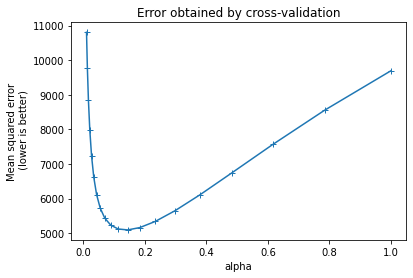

In [24]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Mean squared error\n (lower is better)")
plt.xlabel("alpha")
_ = plt.title("Error obtained by cross-validation")

Como podemos ver, a regularização é como o sal na cozinha: é preciso equilibrar
sua quantidade para obter o melhor desempenho estatístico. Podemos verificar se o melhor
`alpha` encontrado é estável em toda a dobra de validação cruzada.

In [25]:
best_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
best_alphas

[0.08858667904100823,
 0.11288378916846889,
 0.37926901907322497,
 0.14384498882876628,
 0.11288378916846889]

Neste notebook, você aprendeu sobre o conceito de regularização e
a importância do pré-processamento e ajuste de parâmetros.

# 📝 Exercício M4.04

No notebook anterior, vimos o efeito de aplicar alguma regularização
no coeficiente de um modelo linear.

Neste exercício, estudaremos a vantagem de usar alguma regularização
ao lidar com recursos correlacionados.

Vamos primeiro criar um conjunto de dados de regressão. Este conjunto de dados conterá 2.000
amostras e 5 recursos dos quais apenas 2 recursos serão informativos.

In [26]:
from sklearn.datasets import make_regression

data, target, coef = make_regression(
    n_samples=2_000, n_features=5, n_informative=2, shuffle=False,
    coef=True, random_state=0, noise=30,)

Ao criar o conjunto de dados, `make_regression` retorna o coeficiente verdadeiro
usado para gerar o conjunto de dados. Vamos plotar essas informações.

Features 0     9.566665
Features 1    40.192077
Features 2     0.000000
Features 3     0.000000
Features 4     0.000000
dtype: float64

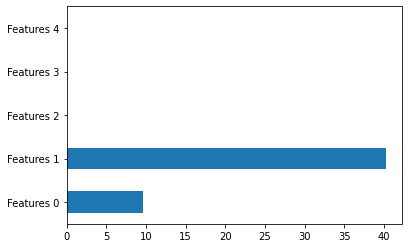

In [27]:
import pandas as pd

feature_names = [f"Features {i}" for i in range(data.shape[1])]
coef = pd.Series(coef, index=feature_names)
coef.plot.barh()
coef

Crie um regressor `LinearRegression` e ajuste em todo o conjunto de dados e
verifique o valor dos coeficientes. São os coeficientes do linear
regressor próximo aos coeficientes usados para gerar o conjunto de dados?

In [28]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(data, target)
linear_regression.coef_

array([10.89587004, 40.41128042, -0.20542454, -0.18954462,  0.11129768])

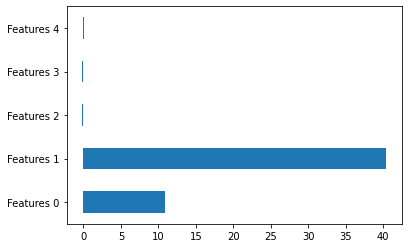

In [29]:
feature_names = [f"Features {i}" for i in range(data.shape[1])]
coef = pd.Series(linear_regression.coef_, index=feature_names)
_ = coef.plot.barh()

Vemos que os coeficientes estão próximos aos coeficientes usados para gerar
o conjunto de dados. A dispersão é de fato causada pelo ruído injetado durante o
geração de conjunto de dados.

Agora, crie um novo conjunto de dados que será o mesmo que `dados` com 4 adicionais
colunas que irão repetir duas vezes os recursos 0 e 1. Este procedimento irá criar
recursos perfeitamente correlacionados.

In [30]:
# solution
import numpy as np

data = np.concatenate([data, data[:, [0, 1]], data[:, [0, 1]]], axis=1)

Ajuste novamente o regressor linear neste novo conjunto de dados e verifique os coeficientes. O que você observa?

In [31]:
# solution
linear_regression = LinearRegression()
linear_regression.fit(data, target)
linear_regression.coef_

array([ 3.63195668, 13.47042681, -0.20542454, -0.18954462,  0.11129768,
        3.63195668, 13.47042681,  3.63195668, 13.47042681])

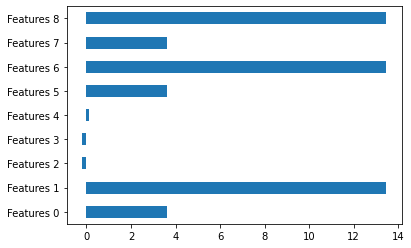

In [32]:
feature_names = [f"Features {i}" for i in range(data.shape[1])]
coef = pd.Series(linear_regression.coef_, index=feature_names)
_ = coef.plot.barh()

Vemos que os valores dos coeficientes estão longe do que se poderia esperar. Ao repetir os recursos informativos, seria de se esperar que esses coeficientes fossem igualmente informativos.

Em vez disso, vemos que alguns coeficientes têm uma grande norma ~ 1e14. Na verdade, significa que tentamos resolver um problema matemático mal colocado. Na verdade, encontrar coeficientes em uma regressão linear envolve a inversão da matriz np.dot (data.T, data), o que não é possível (ou leva a erros numéricos elevados).

Crie um regressor de crista e ajuste no mesmo conjunto de dados. Verifique os coeficientes. O que você observa?

In [33]:
# solution
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(data, target)
ridge.coef_

array([ 3.6313933 , 13.46802113, -0.20549345, -0.18929961,  0.11117205,
        3.6313933 , 13.46802113,  3.6313933 , 13.46802113])

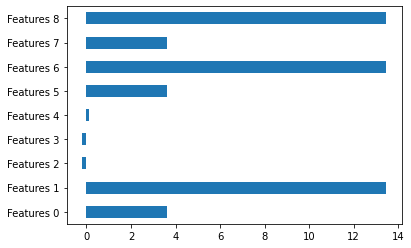

In [34]:
coef = pd.Series(ridge.coef_, index=feature_names)
_ = coef.plot.barh()

Vemos que a penalidade aplicada aos pesos dá melhores resultados: os valores dos coeficientes não sofrem de problemas numéricos. De fato, a matriz a ser invertida internamente é np.dot (data.T, data) + alfa * I. Adicionar essa penalidade alfa permite a inversão sem problema numérico.

Você pode encontrar a relação entre os coeficientes de crista e os coeficientes originais?

In [35]:
# solution
ridge.coef_[:5] * 3

array([10.89417991, 40.40406338, -0.61648035, -0.56789883,  0.33351616])